In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # 대화형 모드

In [11]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

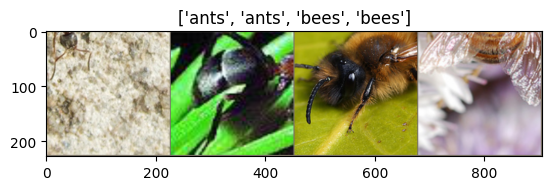

In [13]:
def imshow(inp, title=None):
    """tensor를 입력받아 일반적인 이미지로 보여줍니다."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # 모델을 학습 모드로 설정
                else:
                    model.eval()   # 모델을 평가 모드로 설정

                running_loss = 0.0
                running_corrects = 0

                # 데이터를 반복
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # 매개변수 경사도를 0으로 설정
                    optimizer.zero_grad()

                    # 순전파
                    # 학습 시에만 연산 기록을 추적
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # 학습 단계인 경우 역전파 + 최적화
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # 통계
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # 모델을 깊은 복사(deep copy)함
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # 가장 나은 모델 가중치를 불러오기
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [19]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, ``nn.Linear(num_ftrs, len (class_names))`` 로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\626-36/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:05<00:00, 8.11MB/s]


In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4959 Acc: 0.7746
val Loss: 0.2001 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.5070 Acc: 0.7951
val Loss: 0.4316 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.5979 Acc: 0.8074
val Loss: 0.2605 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.5071 Acc: 0.7828
val Loss: 0.3316 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.5209 Acc: 0.7582
val Loss: 0.2071 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.5547 Acc: 0.8156
val Loss: 0.3336 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.5607 Acc: 0.7705
val Loss: 0.4194 Acc: 0.8170

Epoch 7/24
----------
train Loss: 0.5949 Acc: 0.7787
val Loss: 0.2405 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.2518 Acc: 0.8934
val Loss: 0.2114 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3121 Acc: 0.8484
val Loss: 0.2137 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3427 Acc: 0.8648
val Loss: 0.2029 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2513 Acc: 0.8852
val Loss: 0.2039 Acc: 0.9281

Ep

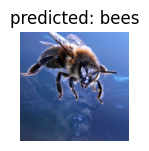

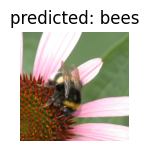

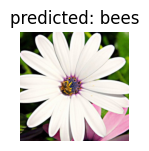

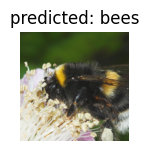

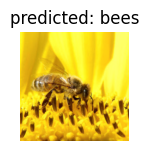

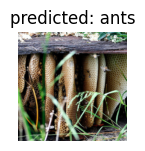

In [23]:
visualize_model(model_ft)

In [25]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [27]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5423 Acc: 0.6557
val Loss: 0.2564 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.4706 Acc: 0.7869
val Loss: 0.1768 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.5072 Acc: 0.8074
val Loss: 0.1829 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.4753 Acc: 0.7828
val Loss: 0.1964 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4645 Acc: 0.7951
val Loss: 0.1938 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.5602 Acc: 0.7705
val Loss: 0.1769 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.6308 Acc: 0.7705
val Loss: 0.1919 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3632 Acc: 0.8566
val Loss: 0.1807 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.4203 Acc: 0.8074
val Loss: 0.1784 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.2723 Acc: 0.8975
val Loss: 0.1879 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3191 Acc: 0.8648
val Loss: 0.1954 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3516 Acc: 0.8525
val Loss: 0.1860 Acc: 0.9477

Ep

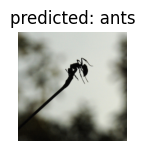

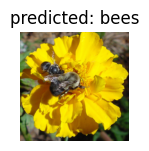

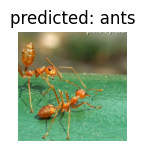

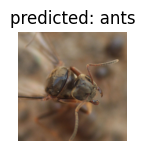

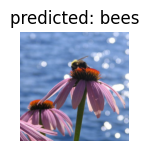

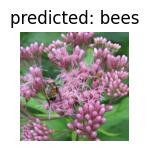

In [29]:
visualize_model(model_conv)

plt.ioff()
plt.show()